In [7]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

2.2.0
2.3.0-tf


## tensor
- tensor에는 변수와 상수가 있음.

In [ ]:
const_ts = tf.constant(2.5)
print(const_ts)
var_ts = tf.Variable(2.5)
print(var_ts)

tf.Tensor(2.5, shape=(), dtype=float32)
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.5>


### 연산하기
- 변수 연산 시, assign 함수를 이용해야 변수를 유지할 수 있음(아니면 상수로 변함)
    - assign: 값을 완전히 할당. =에 해당
    - assign_add: 값을 증가. +=에 해당
    - assign_sub: 값을 감소. -=에 해당

In [ ]:
# 다음과 같이 하면 안된다!. 변수헝 텐서가 상수형 텐서로 변한다!
sum_ts = var_ts + const_ts
sum_ts

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [ ]:
var_ts.assign_add(const_ts)
var_ts

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>

### 기타

####tensor 안의 값 확인하기

In [ ]:
var_ts = tf.Variable([2.5, 3.5])
var_ts

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2.5, 3.5], dtype=float32)>

In [ ]:
var_ts.eval()

RuntimeError: ignored

In [ ]:
xLstm.eval(session=sess)
sess = tf.Session()
value = sess.run(알고 싶은 tensor)
print(value)

# https://d-tail.tistory.com/26

### numpy and tensor

In [ ]:
import numpy as np
a_np = np.array(2.5)

print(c_tf)  # dtype=float32. 정확도 < 속도 중시
print(a_np.dtype)  # float64. 정확도 < 속도 중시

tf.Tensor(2.5327635, shape=(), dtype=float32)
float64


In [ ]:
c_tf.numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=2.5327635>>

In [ ]:
c_tf.numpy()   # tensor -> np array

2.5327635

In [ ]:
a_np * c_tf  # np와 tensor 바로 연산 가능. 연산 결과는 tensor로 반환

<tf.Tensor: shape=(), dtype=float32, numpy=6.3319087>

## 전 과정 따라가보기
인공신경망을 이용하여 Iris 데이터를 학습한다.(multi class classification)

In [1]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

np.random.seed(42)

이 경우, X는 matrix이기에 capital letter로,
target variable은 a single column of values이기에 소문자 y로 표현

In [2]:
# Iris data set을 읽어온다
iris = load_iris()

X = iris.data.astype(np.float32)
X = (X - X.mean(axis=0)) / X.std(axis=0)  # 표준화

y = to_categorical(iris.target.astype(np.float32))  # one-hot으로 변환. 
# np.argmax(y, axis=1)  # 만약 위에서 one-hot으로 변환한것을 다시 반대로 복구하고 싶다면...

print(X[0])
print(X.shape, y.shape)

[-0.90068316  1.0190046  -1.3402262  -1.3154445 ]
(150, 4) (150, 3)


In [3]:
# 학습데이터와 시험데이터로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [4]:
# 이렇게 차원을 미리 지정해두고 하자!
n_hiddens = [8, 4]     # hidden layer의 neuron 개수 
n_output = 3           # output layer의 neuron 개수. len(np.unique(y)) 넣어주면 개별 값의 3개 요소 각각에 대해 0,1을 비교함에 따라 t/f가 되어 2를 리턴하는 것으로 보임

#### Tensorflow

In [ ]:
# Mini-batch update를 위한 학습용 데이터를 만든다.
trainDS = tf.data.Dataset.from_tensor_slices((trainX, trainY))\
            .shuffle(buffer_size=trainX.shape[0])\
            .batch(batch_size = 50)
print(type(trainDS))

# dataset = tf.data.Dataset.from_tensor_slices(realData).shuffle(1000)
# dataset = dataset.batch(nBatchSize, drop_remainder=True).prefetch(1)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [ ]:
print(trainX.shape, trainY.shape)

(120, 4) (120, 3)


In [ ]:
# 그래프를 생성한다. 변수 초기화
# hidden layer의 Weight (Wh)와 Bias (Bh)
Wh = tf.Variable(tf.random.normal([nInput, nHidden]), dtype=tf.float32)  # normal distribution으로 초기화
Bh = tf.Variable(tf.zeros(nHidden), dtype=tf.float32)

# output layer의 Weight (Wo)와 Bias (Bo)
Wo = tf.Variable(tf.random.normal([nHidden, nOutput]), dtype=tf.float32)
Bo = tf.Variable(tf.zeros(nOutput), dtype=tf.float32)

In [ ]:
# Cost function 정의
def lossCE(x, y, C):
    predY = predict(x)
    clipY = tf.clip_by_value(predY, 0.001, 0.999)   # log(0)를 방지한다. min(0.001)보다 작은 숫자는 min값으로...
    
    # categorical cross-entropy(CCE) 사용, 이해를 돕기 위해 원시적으로 코딩한다. 
    loss = -tf.reduce_mean(tf.reduce_mean(y * tf.math.log(clipY), axis=1))      
    # loss = -tf.reduce_mean(y * tf.math.log(clipY) + (1-y) * tf.math.log(1-clipY))  # BCE

    # L2 regularization 적용. C는 regul_const
    regul_term = C * tf.reduce_mean(tf.square(Wh)) +\
            C * tf.reduce_mean(tf.square(Bh)) +\
            C * tf.reduce_mean(tf.square(Wo)) +\
            C * tf.reduce_mean(tf.square(Bo))
            
    return loss + regul_term

# 학습할 optimizer를 정의한다
opt = optimizers.Adam(learning_rate = 0.01)

In [ ]:
# Mini-batch 방식으로 신경망을 학습한다.
trainLoss = []
testLoss = []
C = 0.01     # regularization constant

# 인공신경망에 inputX, outputY를 100번 집어 넣어서 학습 시킨다.
# 입력 해주는게 loss func와 variable list 뿐이다? 각 variable에 
for epoch in range(100):
    # Mini-batch update
    for bx, by in trainDS:
        opt.minimize(lambda: lossCE(bx, by, C), var_list = [Wh, Bh, Wo, Bo])
        
    trainLoss.append(lossCE(trainX, trainY, C))
    testLoss.append(lossCE(testX, testY, C))
    print('epoch = %d, train_loss = %.4f, test_loss = %.4f' % 
          (epoch, trainLoss[-1], testLoss[-1]))

In [ ]:
# 출력을 계산한다.
def predict(x):
    # Hidden layer의 출력값. activation function은 ReLu
    H1 = tf.nn.relu(tf.matmul(x, Wh) + Bh)  # tf.sigmoid()

    # dropout 적용. training 할 때만 적용해야 함. scale은 알아서 해줌
    if train:    
        H1 = tf.nn.dropout(H1, rate=0.3)

    # Output layer의 출력값. activation function은 sigmoid
    return tf.nn.softmax(tf.matmul(H1, Wo) + Bo)
    
# 학습이 완료되면,  Wh, Bh, Wo, Bo 이 모두 업데이트 되었으면,  testX를 넣어서 출력값을 확인한다.
# textX의 출력값 (추정값)과 testY (실제값)를 이용하여 정확도를 측정한다.
yHat = predict(testX).numpy()
predY = np.argmax(yHat, axis=1)
accuracy = (np.argmax(testY, axis=1) == predY).mean()

# Weight, Bias의 최종값을 확인해 본다
print("\nWh = \n", np.round(Wh.numpy(), 3))
print("\nBh = \n", np.round(Bh.numpy(), 3))
print("\nWo = \n", np.round(Wo.numpy(), 3))
print("\nBo = \n", np.round(Bo.numpy(), 3))

# regularization 했을 때 wh std가 줄어드는지 확인해보자
print(Wh.numpy().std())

# Loss를 확인한다
plt.figure(figsize=(8, 4))
plt.plot(trainLoss, label='Train loss')
plt.plot(testLoss, label='Test loss')
plt.legend()
plt.title("Loss function")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

print("Accuracy = %.2f" % accuracy)

### keras 이용해서 고수준으로 구현해보기
tf로 구현했던 것과 비교해보면
- biase 만들어줄 필요 없고(알아서 넣어주고)
- dropout을 fit할때는 넣고 predict 할때는 제외하고 해줄 필요 없다(알아서 제외해줌)    
등등 여러가지 신경쓰지 않아도 되도록 해줌

In [5]:
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

#### model 만들기

##### sequencial

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

In [7]:
# 방법1. add 방식
model_seq = Sequential()
# model.add(InputLayer(input_shape=X.shape))
model_seq.add(Dense(n_hiddens[0], activation='relu', input_shape=X.shape[1:]))  # 위처럼 InputLayer 따로 넣어주는거나 첫번째 레이어 인자로 input_shpae 넣어주는거나 완전 동일
model_seq.add(Dense(n_hiddens[1], activation='relu'))
model_seq.add(Dense(n_output, activation='softmax'))

In [8]:
# 방법2. 층을 하나씩 add하지 않고, sequential 모델 만들때 층의 리스트 전달하기
model_seq = Sequential([
    Dense(n_hiddens[0], activation='relu', input_shape=X.shape[1:]), 
    Dense(n_hiddens[1], activation='relu'),
    Dense(n_output, activation='softmax')    
])

##### 함수형
- `Dense(1)(Input_)` 에서 보듯이 `Dense(1)`라는 객체가 만들어지자마자 바로 입력(Input_)과 함께 함수처럼 호출됨
- python에는 객체를 함수처럼 호출하면 실행되는 `__call__()`메서드가 존재
- 이것이 함수형이라고 불리는 이유

In [9]:
X_train.shape[1:]

(4,)

In [10]:
from tensorflow.keras.layers import Input, Dense

In [55]:
# Input_layer는 bypass. trainable param없음.
Input_ = Input(shape=X_train.shape[1:])  # A shape tuple (integers), not including the batch size. batch_shape=(None, input_shape)sms depreciated
hidden1 = Dense(n_hiddens[0], activation='relu')(Input_)
hidden2 = Dense(n_hiddens[1], activation='relu')(hidden1)
output = Dense(n_output, activation='softmax')(hidden2)
model_func = Model(Input_, output)

#### model compile
모델 fit시 사용할 아래 정보들을 지정해주는 단계
- loss func
- optimizer
- 훈련 및 평가시에 계산할 지표: loss는 기본으로 저장되고 추가적으로 지켜볼 것

In [12]:
model_seq.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.RMSprop(lr=0.05),  # optimizer='rmsprop'로 해줘도 됨. 근데 이렇게 해주면 lr 지정을 못하나?
                metrics=['accuracy'])  # metrics=[keras.metrics.accuracy] 와 동일
# 만약 앞에서 to_categorical로 one-hot으로 안바꿔줬다면 아래와 같이 loss를 sparse~ 로 해주기
### model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.01))

model_seq.summary()  
# Sequential() summary에서는 InputLayer 층이 생략됨

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 15        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 아래에서 metrics 넣어준다고 해서 그거 기준으로 모델 성능을 평가하는게 아닌듯? 그건... loss func에 따른 loss인거고
# 그냥 history에 저장해줄 모니터링할  metric 지정인듯함
model_func.compile(loss='categorical_crossentropy', 
                   optimizer=optimizers.Adam(lr=0.05), 
                   metrics=['accuracy'])
model_func.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 15        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


#### 학습하기(fit)
- 앞 compile에서 지정한 조건에 따라 training
- batch_size, epochs, validation 등을 설정
- `validation_split=0.1`을 쓰면 섞기 전 마지막 10% 데이터를 사용하게 됨
- keras에서는 fit()을 다시 호출하면 중지되었던 곳에서 다시 훈련을 이어가게됨!!

데이터에 대한 가중치 부여해주기   
방법
- 만약 label이 편중되어 있는 데이터라면 `class_weight` 매개변수 지정해주는 것이 좋음. 이로 적게등장하는 클래스에는 높은 가중치를, 많이 등장하는 클래스에는 낮은 가중치를 부여
- 샘플별로 가중치 주려면 `sample_weight` 이용 ( 예를 들어 데이터 소스가 여러개인데 특정 소스의 질이 우수하다면)
- 둘다 사용가능. 둘다 지정되면 두 값을 곱한 가중치로 적용됨

결과
- loss 계산: 해당 sample loss에 가중치를 곱한 후 전체 샘플개수로 나누어 줌
- 다른 측정 지표들에는 가중치를 곱한 후 전체 가중치 합으로 나뉨(이 때는 샘플개수가 아님)
- 샘플 가중치 기본값은 1. 0으로 설정하면 샘플 제외효과

In [20]:
model = model_func

# 출력 안하고 싶으면 verbose=0
# validation_data=(X_valid, y_valid)
history = model.fit(X_train, y_train, batch_size=50, epochs = 100, validation_split=0.2)  

Epoch 1/100
10/10 [==============================] - 0s 20ms/step - loss: 0.6834 - accuracy: 0.6146 - val_loss: 0.7111 - val_accuracy: 0.7917
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5071 - accuracy: 0.8333 - val_loss: 0.4354 - val_accuracy: 0.9167
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.3501 - accuracy: 0.9062 - val_loss: 0.3187 - val_accuracy: 0.9167
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2432 - accuracy: 0.9271 - val_loss: 0.2222 - val_accuracy: 0.9583
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2021 - accuracy: 0.9479 - val_loss: 0.1260 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1527 - accuracy: 0.9583 - val_loss: 0.1033 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1203 - accuracy: 0.9792 - val_loss: 0.1049 - val_accuracy: 1.0000
Epoch 8/100


#### 학습 결과 확인하기

##### History 객체
fit()이 반환하는 History 객체에는 
- 훈련 파라미터(history.params)
- 수행된 에포크 리스트(history.epoch)
- 매 epoch이 끝날 때 마다 훈련/검증세트에 대한 loss 및 지표를 담은 history.hisotory dict

튜닝 할 때는 
learning rate -> optimizer ->다시 lr -> model 구조(layer 수, 뉴런수, activation function 등 모델의 hyperparameter)

In [34]:
print(history.params)
print(history.epoch[:5])
print(list(history.history.keys()))  # history.history는 dict
print(history.history['val_loss'][:5])

{'verbose': 1, 'epochs': 100, 'steps': 10}
[0, 1, 2, 3, 4]
['loss', 'accuracy', 'val_loss', 'val_accuracy']
[0.7110750675201416, 0.43542513251304626, 0.3187222182750702, 0.22221751511096954, 0.12604330480098724]


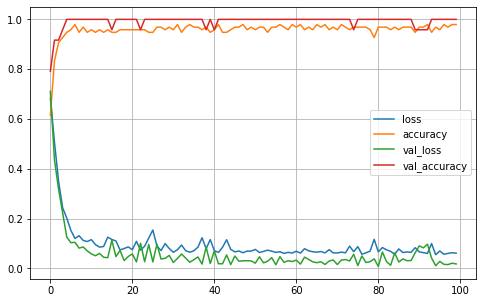

In [23]:
# 그래프그리기 방법1
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

위 그래프에서 val_loss가 더 낮은것 처럼 보이나 
- val_loss는 ephoc이 끝난 후에 계산되고
- loss는 ephoc가 진행되는 동안에 계산됨에 따라
train loss는 ephoc 절반만큼 왼쪽으로 이동해야 함

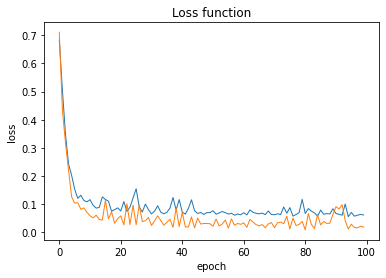

In [37]:
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)

plt.title("Loss function")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:


# 결과를 확인한다
plt.figure(figsize=(10, 4))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.title("Loss function")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

print("Accuracy = %.2f" % accuracy)


##### 레이어별 정보 살펴보기
sequencial은 input layer는 포함안되어있는데 반해    
func은 input layer가 포함되어 있음에 주의

In [ ]:
model_seq.layers # 레이어 리스트 출력하기

In [ ]:
model_func.layers # 레이어 리스트 출력하기

In [ ]:
hidden1 = model_func.layers[1]
hidden1.name

'dense_6'

In [ ]:
model_func.get_layer(hidden1.name)

In [ ]:
model_func.layers[0].get_weights()  # set_weights()도 있음

[]

In [ ]:
weights, biases = model_func.layers[1].get_weights()
weights

array([[ 0.2837277 , -0.0354104 , -0.16292572,  0.4699313 , -0.47513238,
         0.63522965,  0.26144654,  0.63453525],
       [ 0.6279108 , -0.58935285, -0.01746041,  0.03375542, -0.14860642,
         0.432993  ,  0.24685866,  0.39669198],
       [-0.32037234, -0.14531422, -0.08746684, -0.21486261,  0.05345184,
        -0.15433437, -0.29561445, -0.621561  ],
       [ 0.3519097 , -0.34394085, -0.39534485, -0.61325014,  0.21848166,
         0.49108726,  0.06709796, -0.5132761 ]], dtype=float32)

#### test(evaluate)


In [53]:
# 방법1
y_predict_prob = model.predict(X_test) # .predict의 리턴값은 확률임!!!
print(y_predict_prob[0].round(3))  # print(np.round(y_predict_prob[0],3))
y_predict_class = np.argmax(y_predict_prob, axis=1)
accuracy = (np.argmax(y_test, axis=1) == y_predict_class).mean()
print(accuracy)



[0.001 0.997 0.002]
[0.001 0.997 0.002]
1.0
1/1 [==============================] - 0s 983us/step - loss: 0.0234 - accuracy: 1.0000


[0.02340758591890335, 1.0]

In [ ]:
# 방법2: 아니면 evaluate로 한 번에 loss, accuracy 출력(compile 시 넣어준 metric이 출력되는건가?)
model.evaluate(X_test, y_test)

### 병렬적 구조 네트워크 만들기( 함수형)

#### input이 복수개
예시: wide&deep: 입력의 일부 또는 전체가 출력층에 바로 연결되는 구조

- 입력에는 리스트로, 
- fit(), evaluate, predict 등에는 tuple로 전달해줘야 함

In [60]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model

In [59]:
X_train_A, X_train_B = X_train[:, :3], X_train[:, 2:]  # 일부러 겹치게...
X_test_A, X_test_B = X_test[:, :3], X_test[:, 2:] 
print(X_train_A.shape, X_train_B.shape)

(120, 3) (120, 2)


In [63]:
n_input = [X_train_A.shape[1], X_train_B.shape[1]]
n_hiddens = [16, 8]
n_output = 3    

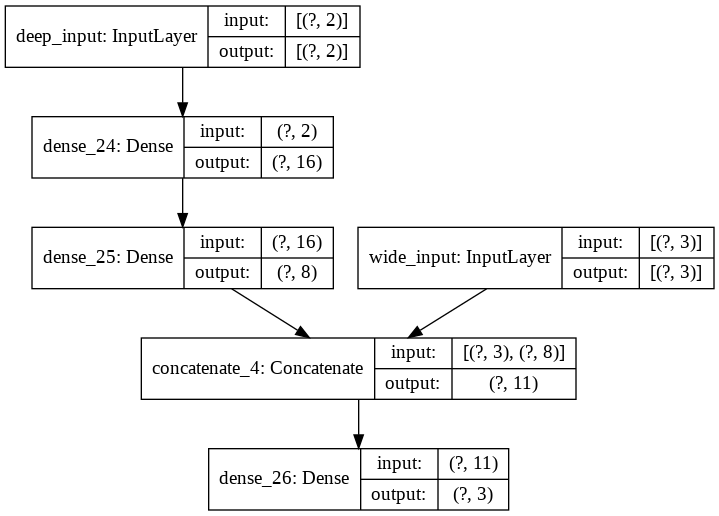

In [68]:
Input_A = Input(shape=[n_input[0]], name="wide_input")   # shape에서 [] 빼도 되긴 하는데...
Input_B = Input(shape=[n_input[1]], name="deep_input") 

hidden1 = Dense(n_hiddens[0], activation='relu')(Input_B)
hidden2 = Dense(n_hiddens[1], activation='relu')(hidden1)
concat = concatenate([Input_A, hidden2])
output = Dense(n_output, activation='softmax')(concat)
model = Model(inputs=[Input_A, Input_B], outputs=[output])
plot_model(model, 'model.png', show_shapes=True)

In [74]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.05))
history = model.fit((X_train_A, X_train_B), y_train,
                    epochs=50, validation_split=0.2, verbose=0)
model.evaluate((X_test_A, X_test_B), y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0176


0.017589455470442772

## KERAS 활용

### 모델 저장과 복원

In [75]:
from tensorflow.keras.models import load_model

In [ ]:
model.save("my_model.h5")
model = load_model("my_model.h5")

### callback 함수
훈련/에포크/각 배치의 시작 또는 끝에 호출할 객체 리스트를 지정

In [ ]:
keras.backend.clear_session()

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

 # train하는 동안 일정 간격(기본으로는 매 에포크)으로 모델의 체크포인트를 저장
 # save_best_only=True 하면 최상의 validation 점수를 기록한 모델일 경우에만 저장
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True) 

# restore_best_weights=True 해주면 EarlyStopping 이후 최상의 가중치를 복원해주기 때문에 
# 해당 세션에서는 따로 저장된 모델 복원할 필요 없음
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 718us/step - loss: 0.4382


사용자 정의 콜백
- on_(train|test|predict)_begin(self, logs = None)
- on_(train|test|predict)_end(self, logs = None)
- on_(train|test|predict)_batch_begin(self, batch, logs = None)

- on_epoch_begin(self, epoch, logs = None)
- on_epoch_end(self, epoch, logs = None)

In [ ]:
#ephoc이 끝날때 마다 val_loss와 loss의 비율을 출력하라
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

354/363 [============================>.] - ETA: 0s - loss: 0.3286
val/train: 1.08
363/363 [==============================] - 0s 1ms/step - loss: 0.3302 - val_loss: 0.3561


### 텐서보드 활용하기
- 이용을 위해서는 event file이라는 binary file로 시각화하려는 데이터를 출력해야함
    - 이 안에 들어가 있는 binary data record를 summary라고 부름

실행 순서
- 프로그램이 실행할 때 마다 서로 다른 sub dir에 이벤트를 기록하도록 해주기
- 텐서보드 서버는 log dir를 모니터링하다가 변경이되면 자동으로 읽어와 그래프 업데이트 해줌


In [2]:
import os
# 사용할 root dir 정의
root_logdir = os.path.join(os.curdir, "my_logs")

In [11]:
# 실행할 때 마다 다른 sub dir 경로 생성해주는 함수
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_07_16-00_52_42'

In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

##### 텐서보드 실행하기

- 터미널에서 실행하기

터미널을 열고 텐서보드가 설치된 가상 환경을 활성화합니다. 그다음 노트북 디렉토리로 이동하여 다음 명령을 입력하세요:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

그다음 웹 브라우저를 열고 [localhost:6006](http://localhost:6006)에 접속하면 텐서보드를 사용할 수 있습니다. 사용이 끝나면 터미널에서 Ctrl-C를 눌러 텐서보드 서버를 종료하세요.

- 텐서보드의 주피터 확장 사용하기(이 명령은 텐서보드가 로컬 컴퓨터에 설치되어 있어야 합니다):

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [ ]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2020_05_18-21_10_05'

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5530 - val_loss: 302.8539
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 68.3936 - val_loss: 0.9455
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.9222 - val_loss: 0.9269
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8909 - val_loss: 0.8038
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8633 - val_loss: 0.8012
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8928 - val_loss: 1.0847
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 1.0071 - val_loss: 0.8835
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8885 - val_loss: 0.8744
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8681 - val_loss: 0.8427
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8451 - val_loss: 0.8

텐서보드에 실행 결과가 2개 있습니다. 학습 곡선을 비교해 보세요.

사용할 수 있는 로깅 옵션을 확인해 보죠:

In [ ]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



가중치 초기화 하기

In [ ]:
kernel_initializer=
bias_initializer=

### 직접 loss function 만들어 활용하기

In [ ]:
## 내가 loss func 만들어서 적용해보기
# 두 인자 순서 바뀌면 안됨. 
# 만든 함수를 compile의 loss로 전달하면
# predY는 내부적으로 계산된 값을, trueY에는 아래 fit에서 넣어주는 trainY을 자동으로 넣어주게 되어있음
def my_loss(trueY, predY):  
    loss = -K.mean(trueY * K.log(predY + 1e-6)\
                    + (1 - trueY) * K.log(1 - predY + 1e-6))
    return loss

## 내가 원하는 인자(상수)를 추가로 loss에 전달하고 싶을 때.
# def my_loss2(trueY, predY, r) 라고 선언하고 아래서 loss=my_loss(0.2) 식으로 부르면 오류남
# 다음과 같이 inner function 방식으로 구현해줘야함
# 만약 변수를 전달하고 싶다면 다른 방법을 써야함(모델의 input을 추가로 하나더 만들어서 변수를 전달해준다든지)
def my_loss2(r):  
    def loss(trueY, predY):       
        bce = -K.mean(trueY * K.log(predY + 1e-6)\
                    + (1 - trueY) * K.log(1 - predY + 1e-6))
        mse = K.mean(K.square(trueY - predY))
        return r * bce + (1-r) * mse
    return loss

# model.compile(loss=my_loss, optimizer=optimizers.Adam(lr=0.01))
# model.compile(loss=my_loss2(0.7), optimizer=optimizers.Adam(lr=0.01))

## 기타 예시
이차방정식 추정
- x, y 만족하는 w1, w2, b를 찾는다.
- y = w1x^2 + w2x + b -->  w1 = 2, w2 = 3, b = 5가 나와야 한다.

In [ ]:
# y = 2x^2 + 3x + 5 일 때 x, y 데이터 집합을 생성한다
x = np.array(np.arange(-5, 5, 0.1))
y = 2 * x * x + 3 * x + 5  # 이렇게 정답값으로 데이터를 생성...
print(x[:3])
print(y[:3])

[-5.  -4.9 -4.8]
[40.   38.32 36.68]


### tensorflow로 직접 구현해보기

- GradientTape (그라디언트 테이프)
    - 텐서플로는 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것) 을 위한 tf.GradientTape API를 제공합니다.

    - tf.GradientTape는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록"합니다. 이 때 변수인지 상수인지를 구분해서 상수에 대해서는 하나씩 차례로 넣어준다??

    - 그 다음 텐서플로는 후진 방식 자동 미분(reverse mode differentiation)을 사용해 테이프에 "기록된" 연산의 그래디언트를 계산합니다.

epoch = 0, loss = 15.3396
epoch = 10, loss = 7.1791
epoch = 20, loss = 5.3826
epoch = 30, loss = 4.7400
epoch = 40, loss = 4.1643
epoch = 50, loss = 3.6579
epoch = 60, loss = 3.2357
epoch = 70, loss = 2.9064
epoch = 80, loss = 2.6668
epoch = 90, loss = 2.5011
epoch = 100, loss = 2.3874
epoch = 110, loss = 2.3059
epoch = 120, loss = 2.2426
epoch = 130, loss = 2.1889
epoch = 140, loss = 2.1400
epoch = 150, loss = 2.0936
epoch = 160, loss = 2.0483
epoch = 170, loss = 2.0036
epoch = 180, loss = 1.9592
epoch = 190, loss = 1.9148
epoch = 200, loss = 1.8706
epoch = 210, loss = 1.8263
epoch = 220, loss = 1.7820
epoch = 230, loss = 1.7378
epoch = 240, loss = 1.6935
epoch = 250, loss = 1.6493
epoch = 260, loss = 1.6050
epoch = 270, loss = 1.5608
epoch = 280, loss = 1.5165
epoch = 290, loss = 1.4723
epoch = 300, loss = 1.4280
epoch = 310, loss = 1.3838
epoch = 320, loss = 1.3396
epoch = 330, loss = 1.2953
epoch = 340, loss = 1.2511
epoch = 350, loss = 1.2068
epoch = 360, loss = 1.1626
epoch = 370

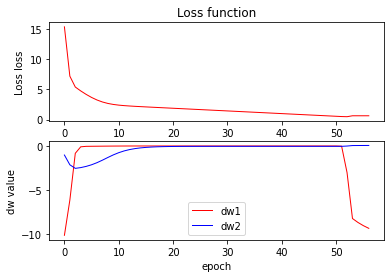

In [ ]:
# 
lr = 0.01   # learning rate

# 그래프를 생성한다.   
w1 = tf.Variable(1.0)
w2 = tf.Variable(1.0)
b = tf.Variable(1.0)

histLoss = []
dw1_log = []
dw2_log = []

early_stop_counter = 0
for epoch in range(1000):

    # 이 with문 안에서 모든 데이터에 대한 연산을 시행함.
    with tf.GradientTape() as tape: #
        # loss 함수 : root mean squared error
        loss = tf.sqrt(tf.reduce_mean(tf.square(w1 * x * x + w2 * x + b - y)))

    # loss에 대한 각 variable들의 미분값을 계산한다.
    dw1, dw2, db = tape.gradient(loss, [w1, w2, b])
    
    # variable들을 업데이트한다 (Gradient descent)
    w1.assign_sub(lr * dw1)     # w1 <- w1 - lr * dw1의 의미. w1 = w1 - lr*dw1 이렇게 해주면 변수가 상수로 변하므로 안됨
    w2.assign_sub(lr * dw2)     # w2.assign(w2 - lr * dw2.numpy())와 동일함
    b.assign_sub(lr * db)


    if epoch % 10 == 0:
        if len(histLoss) > 0 and  histLoss[-1] - loss < 0.0001:
            early_stop_counter+=1
            print(early_stop_counter)
        histLoss.append(loss.numpy())
        dw1_log.append(dw1)
        dw2_log.append(dw2)
        print("epoch = %d, loss = %.4f" % (epoch, loss.numpy()))
        
        if early_stop_counter > 3:
            break
    
print("\n추정 결과 :")
print("w1 = %.2f" % w1.numpy())
print("w2 = %.2f" % w2.numpy())
print("b = %.2f" % b.numpy())
print("final loss = %.4f" % loss.numpy())

fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].plot(histLoss, color='red', linewidth=1)
axes[0].set_title("Loss function")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("Loss loss")

axes[1].plot(dw1_log, color='red', linewidth=1, label="dw1")
axes[1].plot(dw2_log, color='blue', linewidth=1, label="dw2")
plt.legend()
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("dw value")

plt.show()

#### optimizer


추정 결과 :
w1 = 2.00
w2 = 3.00
b = 5.00
final loss = 0.0108


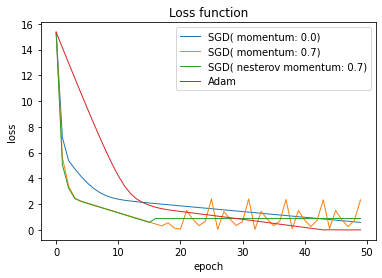

In [ ]:
# Tensorflow 버전 : Optimizers 기능을 사용한 예시 (1) - SGD + Momentum
# x, y 데이터 세트가 있을 때, 이차 방정식 y = w1x^2 + w2x + b를 만족하는
# parameter w1, w2, b를 추정한다.
# -------------------------------------------------------------------
from tensorflow.keras import optimizers
import collections

# y = 2x^2 + 3x + 5 일 때 x, y 집합을 생성한다
x = np.array(np.arange(-5, 5, 0.1))
y = 2 * x * x + 3 * x + 5

# optimizers 선언
opt_sgd = optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
opt_momentum_basic = optimizers.SGD(learning_rate=0.01, momentum=0.7, nesterov=False)
opt_momentum_nesterov = optimizers.SGD(learning_rate=0.01, momentum=0.7, nesterov=True)
opt_adam = optimizers.Adam(learning_rate=0.01)
opt_list = [opt_sgd, opt_momentum_basic, opt_momentum_nesterov, opt_adam]

histLoss_dict = collections.defaultdict(list)

for opt in opt_list:
    # 가중치 초기값 설정  
    w1 = tf.Variable(1.0)
    w2 = tf.Variable(1.0)
    b = tf.Variable(1.0)
    var_list = [w1, w2, b]  # variable list

    for epoch in range(500):
        with tf.GradientTape() as tape:
            # root mean squared error
            loss = tf.sqrt(tf.reduce_mean(tf.square(w1 * x * x + w2 * x + b - y)))
            
        # loss에 대한 각 variable들의 미분값을 계산한다.
        grads = tape.gradient(loss, var_list)
        
        # variable들을 업데이트한다 (Gradient descent)
        opt.apply_gradients(zip(grads, var_list))
        
        if epoch % 10 == 0:
            histLoss_dict[opt].append(loss.numpy())
            #print("epoch = %d, loss = %.4f" % (epoch, loss.numpy()))
    
print("\n추정 결과 :")
print("w1 = %.2f" % w1.numpy())
print("w2 = %.2f" % w2.numpy())
print("b = %.2f" % b.numpy())
print("final loss = %.4f" % loss.numpy())


# 그래프 그리기
for k, v in histLoss_dict.items():
    name = k.get_config()['name'] # {'name': 'SGD', 'learning_rate': 0.01, 'decay': 0.0, 'momentum': 0.7, 'nesterov': True}
    if name == "SGD":
        momentum = k.get_config()['momentum']
        nesterov = " nesterov" if k.get_config()['nesterov'] else ""
        label = f"{name}({nesterov} momentum: {momentum:.1f})"
    else:
        label = f"{name}"
    plt.plot(v,  linewidth=1, label=label) 

plt.title("Loss function")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
# Tensorflow 버전 : Optimizers 기능을 사용한 예시 (2)
# - Adam optimizer를 사용하고, minimize() 함수를 이용한다.
#
# x, y 데이터 세트가 있을 때, 이차 방정식 y = w1x^2 + w2x + b를 만족하는
# parameter w1, w2, b를 추정한다.
# -------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt

# y = 2x^2 + 3x + 5 일 때 x, y 집합을 생성한다
x = np.array(np.arange(-5, 5, 0.1))
y = 2 * x * x + 3 * x + 5

# 그래프를 생성한다.   
w1 = tf.Variable(1.0)
w2 = tf.Variable(1.0)
b = tf.Variable(1.0)

def loss():
    return tf.sqrt(tf.reduce_mean(tf.square(w1 * x * x + w2 * x + b - y)))

# Adam optimizers 기능을 사용한다.
opt = optimizers.Adam(learning_rate = 0.05)

histLoss = []
for epoch in range(300):
    """
    with tf.GradientTape() as tape:
        loss = tf.sqrt(tf.reduce_mean(tf.square(w1 * x * x + w2 * x + b - y)))
    grads = tape.gradient(loss, var_list)
    opt.apply_gradients(zip(grads, var_list))
    histLoss.append(loss.numpy())
    """
    opt.minimize(loss, var_list = [w1, w2, b])
    histLoss.append(loss())
    if epoch % 10 == 0:
        print("epoch = %d, loss = %.4f" % (epoch, histLoss[-1]))
        
print("\n추정 결과 :")
print("w1 = %.2f" % w1.numpy())
print("w2 = %.2f" % w2.numpy())
print("b = %.2f" % b.numpy())

plt.plot(histLoss, color='red', linewidth=1)
plt.title("Loss function")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

ValueError: ignored

### Regression
직선회귀 방법 : Ordinary Least Square

In [ ]:
# 샘플 데이터 1,000개를 생성한다
# y = ax + b + e
def createData(a, b, n):
   resultX = []
   resultY = []
   for i in range(n):
       x = np.random.normal(0.0, 0.5)
       y = a * x + b + np.random.normal(0.0, 0.05)
       resultX.append(x)
       resultY.append(y)
       
   return resultX, resultY

# inputY = 0.1 * inputX + 0.3 + 잔차
x, y = createData(0.1, 0.3, 1000)

#### TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 선형 추정 식을 정의한다
# predY = W * inputX + b
r = tf.random.uniform([1], -1.0, 1.0)
W = tf.Variable(r, name = "W")
b = tf.Variable(tf.zeros([1]), name = "Bias")

# Loss function을 정의한다. (MSE : Mean Square Error)
def loss(x):
    predY = tf.add(tf.multiply(W, x), b)
    return tf.reduce_mean(tf.square(predY - y))

# 학습할 optimizer를 정의한다
opt = optimizers.Adam(learning_rate = 0.05)
    
# 학습한다
trLoss = []
for i in range(100):
    opt.minimize(lambda: loss(x), var_list = [W, b])
    trLoss.append(loss(x))
    
    if i % 20 == 0:
        print("%d) %f" % (i, trLoss[-1]))    

0) 0.251974
50) 0.002588
100) 0.002453
150) 0.002452
200) 0.002452
250) 0.002452



*회귀직선의 방정식 (OLS) : y = 0.1080 * x +  0.3006


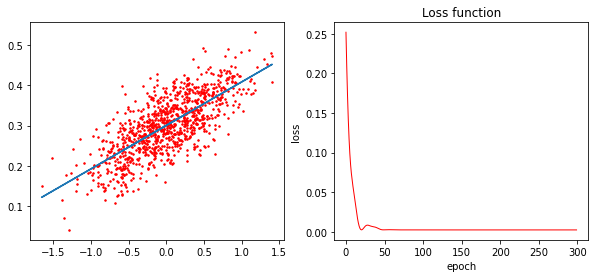

In [ ]:
# 결과를 확인한다
print("\n*회귀직선의 방정식 (OLS) : y = %.4f * x +  %.4f" % (W.numpy(), b.numpy()))
yHat =  W.numpy() * x + b.numpy()

fig = plt.figure(figsize=(10, 4))
p1 = fig.add_subplot(1,2,1)
p2 = fig.add_subplot(1,2,2)

p1.plot(x, y, 'ro', markersize=1.5)
p1.plot(x, yHat)

p2.plot(trLoss, color='red', linewidth=1)
p2.set_title("Loss function")
p2.set_xlabel("epoch")
p2.set_ylabel("loss")
plt.show()

#### KERAS

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 그래프를 생성한다.   
xInput = Input(batch_shape=(None, 1))  # bypass. trainable param없음
yOutput = Dense(1)(xInput)
model = Model(xInput, yOutput)
model.compile(loss='mse', optimizer=optimizers.Adam(lr=0.05))
model.summary()

# 학습한다.
h = model.fit(x, y, batch_size=10, epochs = 100, verbose=0)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________



추정 결과 :
w = 0.12
b = 0.32


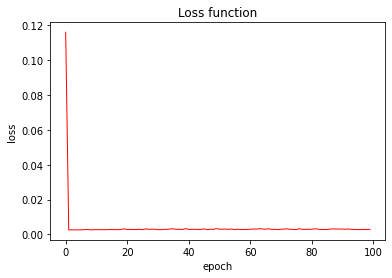

In [ ]:
# 학습 결과를 확인한다.
parameters = model.layers[1].get_weights()
print("\n추정 결과 :")
print("w = %.2f" % parameters[0][0])
print("b = %.2f" % parameters[1][0])

plt.plot(h.history['loss'], color='red', linewidth=1)
plt.title("Loss function")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
a = tf.constant([[1,2],
                 [0,1],
                 [1,2],
                  [2,1],
                  [3,0]])

b = tf.constant([[1,1],
                [0,0],
                [1,0],
                [1,2]])

print(a.shape, b.shape)

(5, 2) (4, 2)


In [ ]:
a_exp = tf.expand_dims(a,0)
b_exp = tf.expand_dims(b,1)
print(a_exp)
print(b_exp)
tf.subtract(a_exp,b_exp)

tf.Tensor(
[[[1 2]
  [0 1]
  [1 2]
  [2 1]
  [3 0]]], shape=(1, 5, 2), dtype=int32)
tf.Tensor(
[[[1 1]]

 [[0 0]]

 [[1 0]]

 [[1 2]]], shape=(4, 1, 2), dtype=int32)


<tf.Tensor: shape=(4, 5, 2), dtype=int32, numpy=
array([[[ 0,  1],
        [-1,  0],
        [ 0,  1],
        [ 1,  0],
        [ 2, -1]],

       [[ 1,  2],
        [ 0,  1],
        [ 1,  2],
        [ 2,  1],
        [ 3,  0]],

       [[ 0,  2],
        [-1,  1],
        [ 0,  2],
        [ 1,  1],
        [ 2,  0]],

       [[ 0,  0],
        [-1, -1],
        [ 0,  0],
        [ 1, -1],
        [ 2, -2]]], dtype=int32)>

In [ ]:
a_exp = tf.expand_dims(a,1)
b_exp = tf.expand_dims(b,0)
print(a_exp.shape, b_exp.shape)
tf.subtract(a_exp,b_exp)

(5, 1, 2) (1, 4, 2)


<tf.Tensor: shape=(5, 4, 2), dtype=int32, numpy=
array([[[ 0,  1],
        [ 1,  2],
        [ 0,  2],
        [ 0,  0]],

       [[-1,  0],
        [ 0,  1],
        [-1,  1],
        [-1, -1]],

       [[ 0,  1],
        [ 1,  2],
        [ 0,  2],
        [ 0,  0]],

       [[ 1,  0],
        [ 2,  1],
        [ 1,  1],
        [ 1, -1]],

       [[ 2, -1],
        [ 3,  0],
        [ 2,  0],
        [ 2, -2]]], dtype=int32)>

FileNotFoundError: ignored